<a href="https://colab.research.google.com/github/francescostreet/ShreckCiuchino2026/blob/main/Notebook%20Sistemato%20aggiornato%20da%20fra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 AN2DL [2025-2026]: Time Series Classification Challenge
This model aims to develop a **deep learning model** on **multivariate temporal series** for pain level classification.

**Authors:** Andrea Venezia - Francesco Urbano Sereno - Francesco Street

**Date:** November 2025

**Report:**

**Challenge:** [AN2DL: Time Series Classification](https://www.kaggle.com/competitions/an2dl2526c1/overview)

**Github:**




## OBJECTIVE:
Build a model capable of distinguishing three classes of pain from multivariate sensor time series:

- **0 — No Pain**  
- **1 — Low Pain**  
- **2 — Other / High Pain**

## WORKFLOW:
The notebook pipeline is:
1. Dataset loading and esploration
2. Data analysis
3. Class imbalance Inspection
4. Apply advanced oversampling (ADASYN)  
5. Prepare data for deep learning  
6. Define, train, and tune neural networks  
7. Performance evaluation  
8. Results Interpretation  

The primary goal is to achieve strong generalization, especially for minority classes.

## 1.**GOOGLE DRIVE CONNECTION**




In [21]:
# @title 1.1 Google Drive Connection
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/Challenge1-Datasets"
%cd $current_dir

print(f"Working directory set to: {current_dir}")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge1-Datasets
Working directory set to: /gdrive/My\ Drive/Challenge1-Datasets


## 2.**LIBRARIES IMPORT**




In [22]:
# @title 2.1 Libraries Import

# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cpu


## 3.**DATA LOADING**

In [23]:
# @title 3.1 Data Loading

# Define dataset directory
current_dir = '/gdrive/My Drive/Challenge1-Datasets'

# Load CSV files
X_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train.csv'))
y_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train_labels.csv'))
X_test = pd.read_csv(os.path.join(current_dir, 'pirate_pain_test.csv'))

# Display dataset info
print(f"Data loaded successfully from {current_dir}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")

Data loaded successfully from /gdrive/My Drive/Challenge1-Datasets
X_train shape: (105760, 40)
y_train shape: (661, 2)
X_test shape:  (211840, 40)


## 4.**DATA ANALISYS**

In [24]:
# @title 4.1 Preprocessing Training and Test DataFrames

# Define column names
column_names = ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(31)]

# Read the Training and Test datasets into a DataFrame with specified column names
df = pd.read_csv('pirate_pain_train.csv', header=0, names=column_names)
df_test = pd.read_csv('pirate_pain_test.csv', header=0, names=column_names)

# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"\n ---DATAFRAMES SHAPE---")
print(f"Training DataFrame shape: {df.shape}")
print(f"Test DataFrame shape: {df_test.shape}")

# Display the first 10 rows of the Training and Testing DataFrames
print("\n ---DATAFRAMES HEAD---")
print(f"Trainig Dataframe head :\n")
display(df.head(10))
print(f"Test Datafreame head:\n")
display(df_test.head(10))


 ---DATAFRAMES SHAPE---
Training DataFrame shape: (105760, 41)
Test DataFrame shape: (211840, 40)

 ---DATAFRAMES HEAD---
Trainig Dataframe head :



,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5,no_pain
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5,no_pain
7,0,7,2,2,2,2,two,two,two,1.038597,...,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5,no_pain
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5,no_pain
9,0,9,0,2,2,2,two,two,two,1.054999,...,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5,no_pain


Test Datafreame head:



,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5
5,0,5,2,2,0,2,two,two,two,0.805308,...,0.000006,0.000003,0.000004,0.000003,0.000014,0.037433,0.034157,0.013880,0.033762,0.5
6,0,6,2,2,0,2,two,two,two,0.878559,...,0.000005,0.000003,0.000007,0.000003,0.000018,0.076399,0.025877,0.049272,0.037960,0.5
7,0,7,2,2,2,2,two,two,two,0.847666,...,0.000003,0.000003,0.000004,0.000005,0.000070,0.041566,0.055916,0.024414,0.026338,0.5
8,0,8,2,2,2,1,two,two,two,0.913557,...,0.000003,0.000007,0.000004,0.000004,0.000050,0.040049,0.047536,0.018454,0.010675,0.5
9,0,9,2,2,2,0,two,two,two,0.880579,...,0.000003,0.000003,0.000005,0.000002,0.000017,0.022977,0.096785,0.035494,0.023898,0.5


In [25]:
# @title 4.2 Dataframe summary
# Display summary of the DataFrame
print(f"\n ---TRAINING DATAFRAME SUMMARY---\n")
df.info()
print(f"\n ---TEST DATAFRAME SUMMARY---\n")
df_test.info()


 ---TRAINING DATAFRAME SUMMARY---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float6

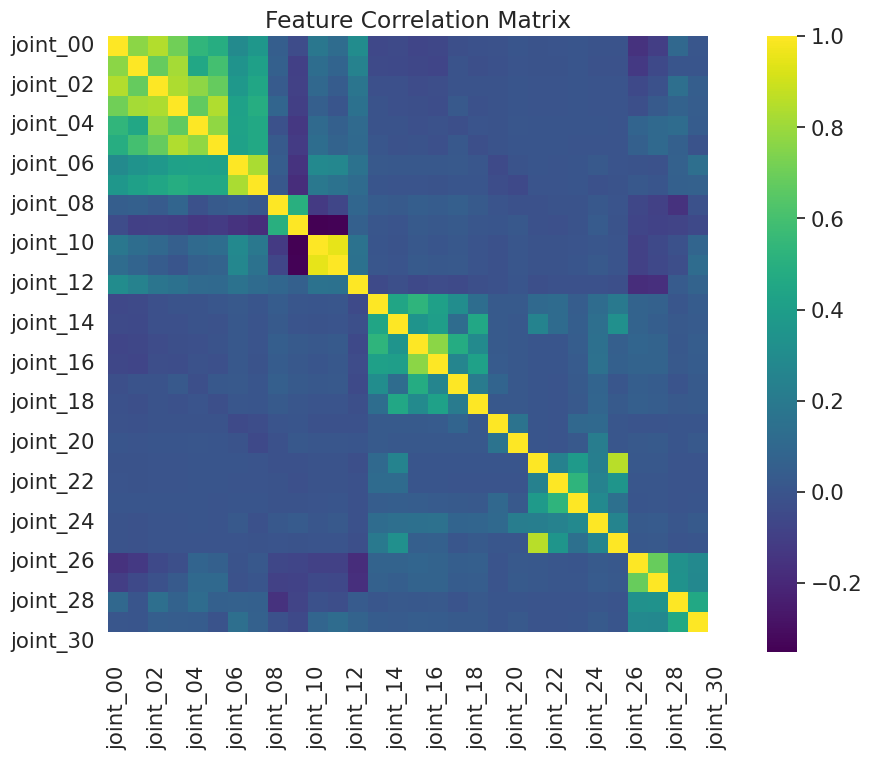

In [26]:
# @title 4.3 Features Correlation Matrix
feature_columns = [f"joint_{i:02d}" for i in range(31)]

plt.figure(figsize=(10,8))
sns.heatmap(df[feature_columns].corr(), cmap='viridis')
plt.title("Feature Correlation Matrix")
plt.show()


The correlation matrix reveals distinct groups of joints that move in a coordinated way, while most joints remain only weakly correlated with each other. This indicates that the dataset doesen't contain redundant features. The presence of both positive and negative correlations suggests complementary joint dynamics that may be informative for pain classification.
Overall, the joint signals provide diverse and non-overlapping information, making them well suited for deep learning models such as LSTMs, CNNs, or attention-based architectures.


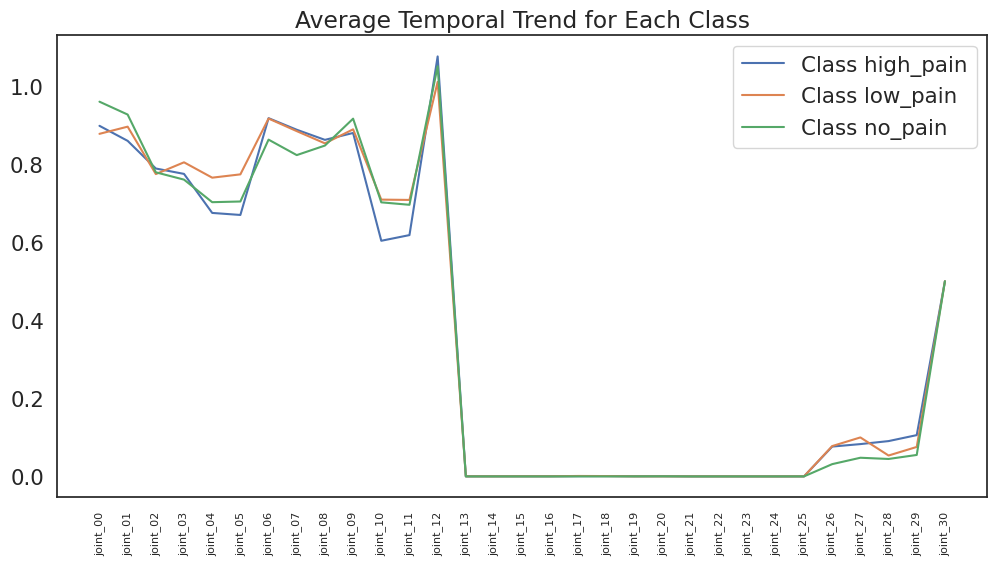

In [27]:
# @title 4.4 Average Temporal Trend for Each Class

df_plot = df.copy()

plt.figure(figsize=(12,6))
for c in sorted(df_plot['label'].unique()):
    mean_signal = df_plot[df_plot['label'] == c][feature_columns].mean()
    plt.plot(mean_signal, label=f'Class {c}')

plt.legend()
plt.title("Average Temporal Trend for Each Class")
plt.xticks(rotation=90, fontsize=8)
plt.show()

From joints 13 to 25, no significant variation emerges either between classes or over time: these features are consistently zero or almost zero across the three labels and therefore do not contribute to the model's learning. We'll see more in detail later if this claim is true or not.

In [29]:
# @title 4.5 Box Plot of All features

# Identify all joint columns
joint_columns = [col for col in df_graph.columns if col.startswith('joint_')]

# Create a box plot for each joint column
plt.figure(figsize=(20, 8)) # Adjust figure size for better readability
sns.boxplot(data=df[joint_columns])
plt.title('Distribution of Joint Values Across All Samples')
plt.xlabel('Joint Index')
plt.ylabel('Value')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'df_graph' is not defined

We observe that the features joint_(from 12 to 25) are all close to 0 with a very little variability, strenghtening our previous claim.

In [ ]:
# Generate descriptive statistics for numerical columns in the DataFrame
print(f"\n--- Statistics ---")
df.describe()

We observe that joint_(from 12 to 25) all have a mean value very close to zero and a very little standard deviation, in the order of 1e-3.

In [ ]:
# @title 4.6 Mean autocorrelation across temporal features

LAG_MAX = 100           # how many steps to check in the future values
THRESHOLD = 0.25        # below this threshold values can be considered uncorrelated (design choice)

df_graph = pd.read_csv("pirate_pain_train.csv")

# Select onyl time varying features
features = [c for c in df_graph.columns if "joint_" in c or "pain_survey_" in c]

# Compute the autocorrelation
autocorrs = []
for lag in range(1, LAG_MAX + 1):
    lag_corrs = []
    for f in features:
        try:
            lag_corr = df_graph[f].autocorr(lag)
            if not np.isnan(lag_corr):
                lag_corrs.append(lag_corr)
        except:
            pass
    if lag_corrs:
        autocorrs.append(np.mean(lag_corrs))
    else:
        autocorrs.append(0)

autocorrs = np.array(autocorrs)

# find where autocorrelation < threshold
below_threshold = np.where(autocorrs < THRESHOLD)[0]
if len(below_threshold) > 0:
    optimal_window = below_threshold[0] + 1  # +1 to compensate starting index
else:
    optimal_window = LAG_MAX

print(f"Suggested window size: {optimal_window} time steps (threshold={THRESHOLD})")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, LAG_MAX + 1), autocorrs, marker="o", markersize=3)
plt.axhline(THRESHOLD, color="r", linestyle="--", label=f"Threshold {THRESHOLD}")
plt.axvline(optimal_window, color="g", linestyle="--", label=f"Suggested window = {optimal_window}")
plt.title("Mean Autocorrelation Across Temporal Features")
plt.xlabel("Lag")
plt.ylabel("Mean Autocorrelation")
plt.legend()
plt.tight_layout()
plt.show()


From this graph we can deduce the optimal Window size, which is between 60 and 80 if we set our threshold between 0.2 and 0.3.

## Dataset:


| Item | Value |
|------|--------|
| Number of features | 39 |
| Window size | 60 |
| Window stride | 20 |
| Train/Validation/Test split | ≈ 80/20/0 |
| Class distribution | Highly imbalanced (≈ 77% / 14% / 8%) |

## 5.DATA MANIPULATION

Features "n_legs", "n_hands", "n_eyes" are objects, need to be converted into float32, in order to be correctly processed by the model.
This step helps understanding the distinct categories within these columns,which helps in deciding how to convert them into a numerical format for modeling.

In [ ]:
# @title 5.1 Inspecting string columns

# Find all the unique string values
for col in ['n_legs', 'n_hands', 'n_eyes']:
    unique_vals = df[col].unique()
    print(f"Unique strings in '{col}': {unique_vals}")

In [ ]:
# @title 5.2 Type Conversion and Variance Filtering

# Columns that need type conversion from object to float32
n_cols = ['n_legs', 'n_hands', 'n_eyes']

# Mapping dictionary to convert string values to numerical (float32)
mapping = {
    'two': 2,
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1
}

# Apply the mapping to the specified columns in both training and test DataFrames
for col in n_cols:
    df[col] = df[col].map(mapping).astype(np.float32)
    df_test[col] = df_test[col].map(mapping).astype(np.float32)

# Convert all 'joint_XX' columns to float32 data type
# This ensures consistency and compatibility for numerical operations
for i in range(31):
  # Check if the column exists before attempting conversion
  if f'joint_{i:02d}' in df.columns:
    df[f'joint_{i:02d}']= df[f'joint_{i:02d}'].astype(np.float32)
  if f'joint_{i:02d}' in df_test.columns:
    df_test[f'joint_{i:02d}']= df_test[f'joint_{i:02d}'].astype(np.float32)


In [ ]:
# @title 5.3 Variance Filtering

# Identify numeric columns in both DataFrames
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols_test = df_test.select_dtypes(include='number').columns

# Calculate variance for each numeric column in the training DataFrame
variance = df[numeric_cols].var()
variance_test = df_test[numeric_cols].var()

# Select columns to keep where variance is greater than a small threshold (1e-3)
cols_to_keep = variance[variance > 1e-4].index
cols_to_keep_test = variance[variance > 1e-4].index

# Filter both DataFrames to keep only the selected columns
# Note: Using the same `cols_to_keep` for both df and df_test ensures consistent feature sets,
# assuming the test set has similar variance properties for features as the training set.
# The 'label' column will be re-merged later for the training dataframe.
df_temp = df[cols_to_keep]
df_test_temp = df_test[cols_to_keep_test]

df = df_temp
df_test = df_test_temp

# Display updated DataFrame information to confirm the changes
print(f"\n--- UPDATED TRAINING DATAFRAME INFO ---\n")
df.info()
print(f"\n--- UPDATED TEST DATAFRAME INFO ---\n")
df_test.info()

We don't consider constant or nearly constant features, setting our variance threshold at 1e-4.

In [ ]:
# @title 5.4 Labels Merging

print(f"\n--- Merging Training Features with Labels ---")

# Merge df with y_train
df = pd.merge(df, y_train, on='sample_index', how='left')

# Check if any labels are missing after merge
missing_labels = df['label'].isna().sum()
if missing_labels > 0:
    print(f"\n Warning: {missing_labels} samples have missing labels after merging with y_train!")
else:
    print("\n All samples matched correctly with their labels.")


# Remove rows with NaNs (train + test)
df_before = df.shape[0]
df_test_before = df_test.shape[0]

df.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)

df_after = df.shape[0]
df_test_after = df_test.shape[0]

print("\n --- Removed rows ---")
print(f"Train: removed {df_before - df_after} rows  ({(1 - df_after/df_before)*100:.2f}%)")
print(f"Test:  removed {df_test_before - df_test_after} rows  ({(1 - df_test_after/df_test_before)*100:.2f}%)")

# Print final shapes
print("\n --- Final Shapes ---")
print(f"Train DataFrame shape: {df.shape}")
print(f"Test  DataFrame shape: {df_test.shape}")

# Preview the first rows
print("\n First 10 Training Rows:")
display(df.head(10))

print("\n First 10 Testing Rows:")
display(df_test.head(10))

In [ ]:
# @title 5.5 Updated Dataset Statistics

# Generate descriptive statistics for numerical columns in the DataFrame
print(f"\n--- Statistics ---")
df.describe()

In [ ]:
# @title 6.3 Distribution of n_legs, n_hands, n_eyes

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of "n_legs", "n_hands", and "n_eyes"', fontsize=16)

# Plot for n_legs
sns.countplot(x='n_legs', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of n_legs')
axes[0].set_xlabel('Number of Legs')
axes[0].set_ylabel('Count')
axes[0].ticklabel_format(style='plain', axis='y')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Plot for n_hands
sns.countplot(x='n_hands', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Distribution of n_hands')
axes[1].set_xlabel('Number of Hands')
axes[1].set_ylabel('Count')
axes[1].ticklabel_format(style='plain', axis='y')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Plot for n_eyes
sns.countplot(x='n_eyes', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('Distribution of n_eyes')
axes[2].set_xlabel('Number of Eyes')
axes[2].set_ylabel('Count')
axes[2].ticklabel_format(style='plain', axis='y')
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 6. GRAPHS


Counts of 0, 1, and 2 for each pain_survey column:
pain_survey_1: {0: 12352, 1: 14031, 2: 79377}
pain_survey_2: {0: 11760, 1: 12983, 2: 81017}
pain_survey_3: {0: 11529, 1: 13573, 2: 80658}
pain_survey_4: {0: 11361, 1: 12905, 2: 81494}

Total aggregated counts of 0, 1, and 2 across all pain_survey columns:
{0: 47002, 1: 53492, 2: 322546}

Counts of 0, 1, and 2 for the 'label' column (after mapping):
{0: 81760, 1: 15040, 2: 8960}


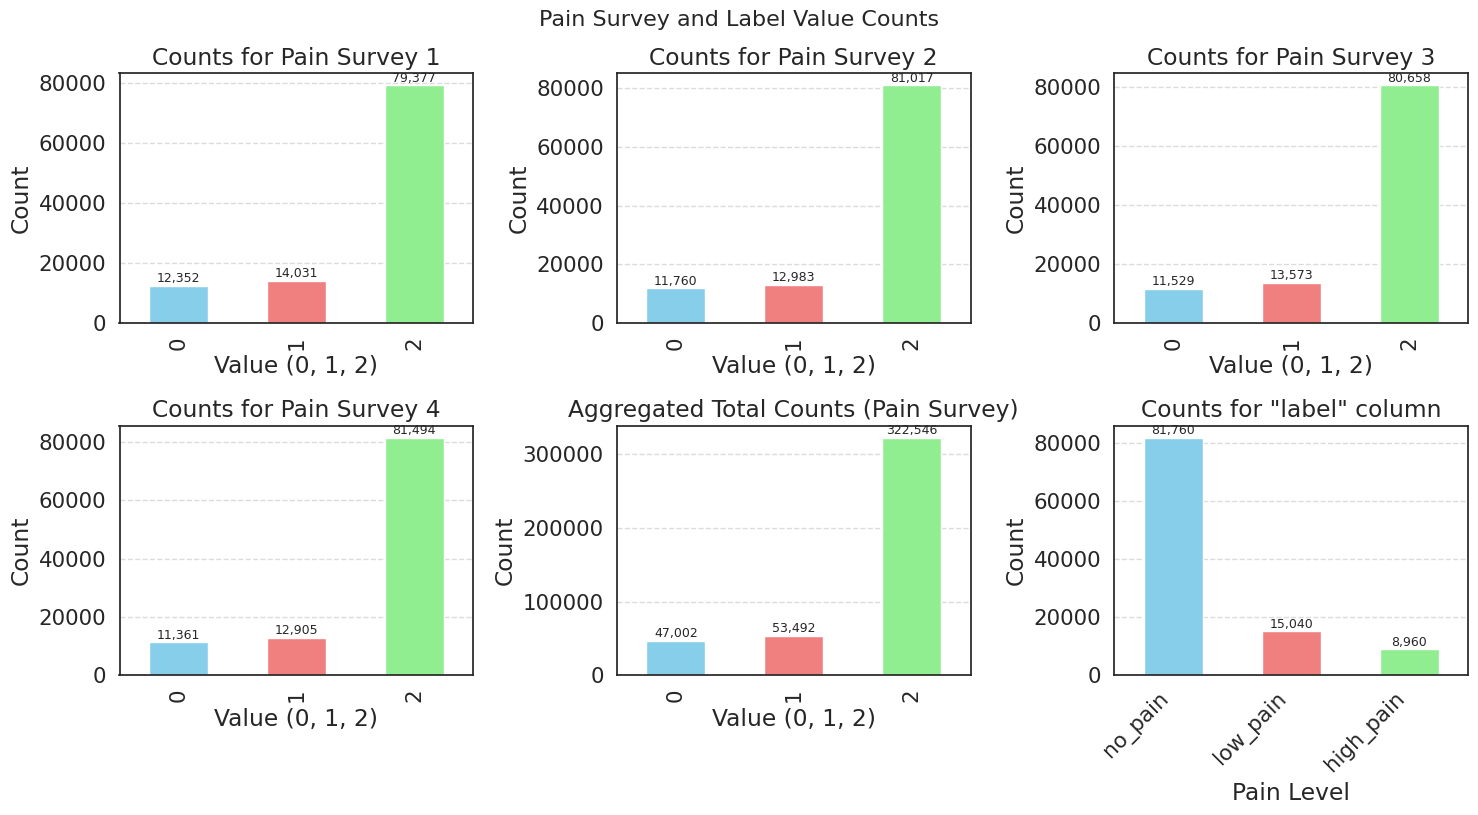

In [17]:
# @title 6.1 Pain Survey and Labels Value Counts

# Define a dictionary of activity names to be mapped into integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}
# Define the inverse mapping for plot labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Identify all'pain_survey' columns.
pain_survey_columns = [col for col in df.columns if col.startswith('pain_survey')]


# Initialize a dictionary to store counts for each pain survey column.
pain_counts = {}

# Iterate through each pain survey column to count occurrences of values 0, 1, and 2.
for col in pain_survey_columns:
    # Get value counts, reindex to ensure all 0, 1, 2 are present, filling missing with 0.
    counts = df[col].value_counts().reindex([0, 1, 2], fill_value=0)
    pain_counts[col] = counts.to_dict()

# Print the individual counts for each pain survey column.
print("\nCounts of 0, 1, and 2 for each pain_survey column:")
for col, counts in pain_counts.items():
    print(f"{col}: {counts}")

# Calculate aggregated counts across all pain_survey columns.
total_pain_counts = {0: 0, 1: 0, 2: 0}
for col, counts in pain_counts.items():
    for value, count in counts.items():
        total_pain_counts[value] += count

# Print the total aggregated counts.
print("\nTotal aggregated counts of 0, 1, and 2 across all pain_survey columns:")
print(total_pain_counts)

# NEW: Calculate counts for the 'label' column by first mapping to numeric
m_labels = df['label'].map(label_mapping)
label_counts_series = m_labels.value_counts().reindex([0, 1, 2], fill_value=0)
print("\nCounts of 0, 1, and 2 for the 'label' column (after mapping):")
print(label_counts_series.to_dict())


# Determine the number of plots needed (individual surveys + one for aggregated total + one for 'label').
num_pain_surveys = len(pain_survey_columns)
num_plots = num_pain_surveys + 1 + 1 # +1 for the aggregated total, +1 for 'label' column

# Dynamically determine the grid size for subplots to arrange them efficiently.
if num_plots <= 3:
    ncols = num_plots
    nrows = 1
elif num_plots <= 6:
    ncols = 3
    nrows = (num_plots + ncols - 1) // ncols # Integer division to calculate rows needed
else:
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

# Create the figure and a set of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten() # Flatten the array of axes for easy iteration.

# Plot individual pain_survey column counts.
for i, col in enumerate(pain_survey_columns):
    counts_series = pd.Series(pain_counts[col])
    # Generate a bar plot for the current pain survey column.
    counts_series.plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'Counts for {col.replace("_", " ").title()}')
    axes[i].set_xlabel('Value (0, 1, 2)')
    axes[i].set_ylabel('Count')
    axes[i].ticklabel_format(style='plain', axis='y') # Disable scientific notation for y-axis.
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Annotate bars with their respective counts.
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Plot aggregated total counts in the next subplot.
total_plot_idx = num_pain_surveys
total_counts_series = pd.Series(total_pain_counts) # Convert dictionary to Series for plotting
total_counts_series.plot(kind='bar', ax=axes[total_plot_idx], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[total_plot_idx].set_title('Aggregated Total Counts (Pain Survey)')
axes[total_plot_idx].set_xlabel('Value (0, 1, 2)')
axes[total_plot_idx].set_ylabel('Count')
axes[total_plot_idx].ticklabel_format(style='plain', axis='y') # Disable scientific notation for y-axis.
axes[total_plot_idx].grid(axis='y', linestyle='--', alpha=0.7)
for p in axes[total_plot_idx].patches:
    axes[total_plot_idx].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# NEW: Plot 'label' column counts in the last subplot.
label_plot_idx = num_pain_surveys + 1
label_counts_series.plot(kind='bar', ax=axes[label_plot_idx], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[label_plot_idx].set_title('Counts for "label" column')
axes[label_plot_idx].set_xlabel('Pain Level')
axes[label_plot_idx].set_ylabel('Count')
axes[label_plot_idx].ticklabel_format(style='plain', axis='y')
axes[label_plot_idx].grid(axis='y', linestyle='--', alpha=0.7)
axes[label_plot_idx].set_xticklabels([inverse_label_mapping[i] for i in sorted(inverse_label_mapping.keys())], rotation=45, ha='right')
for p in axes[label_plot_idx].patches:
    axes[label_plot_idx].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)


# Hide any unused subplots if the number of plots is less than the grid size.
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap and add a super title for the entire figure.
plt.tight_layout()
plt.suptitle('Pain Survey and Label Value Counts', y=1.02, fontsize=16) # Updated super title
plt.show()

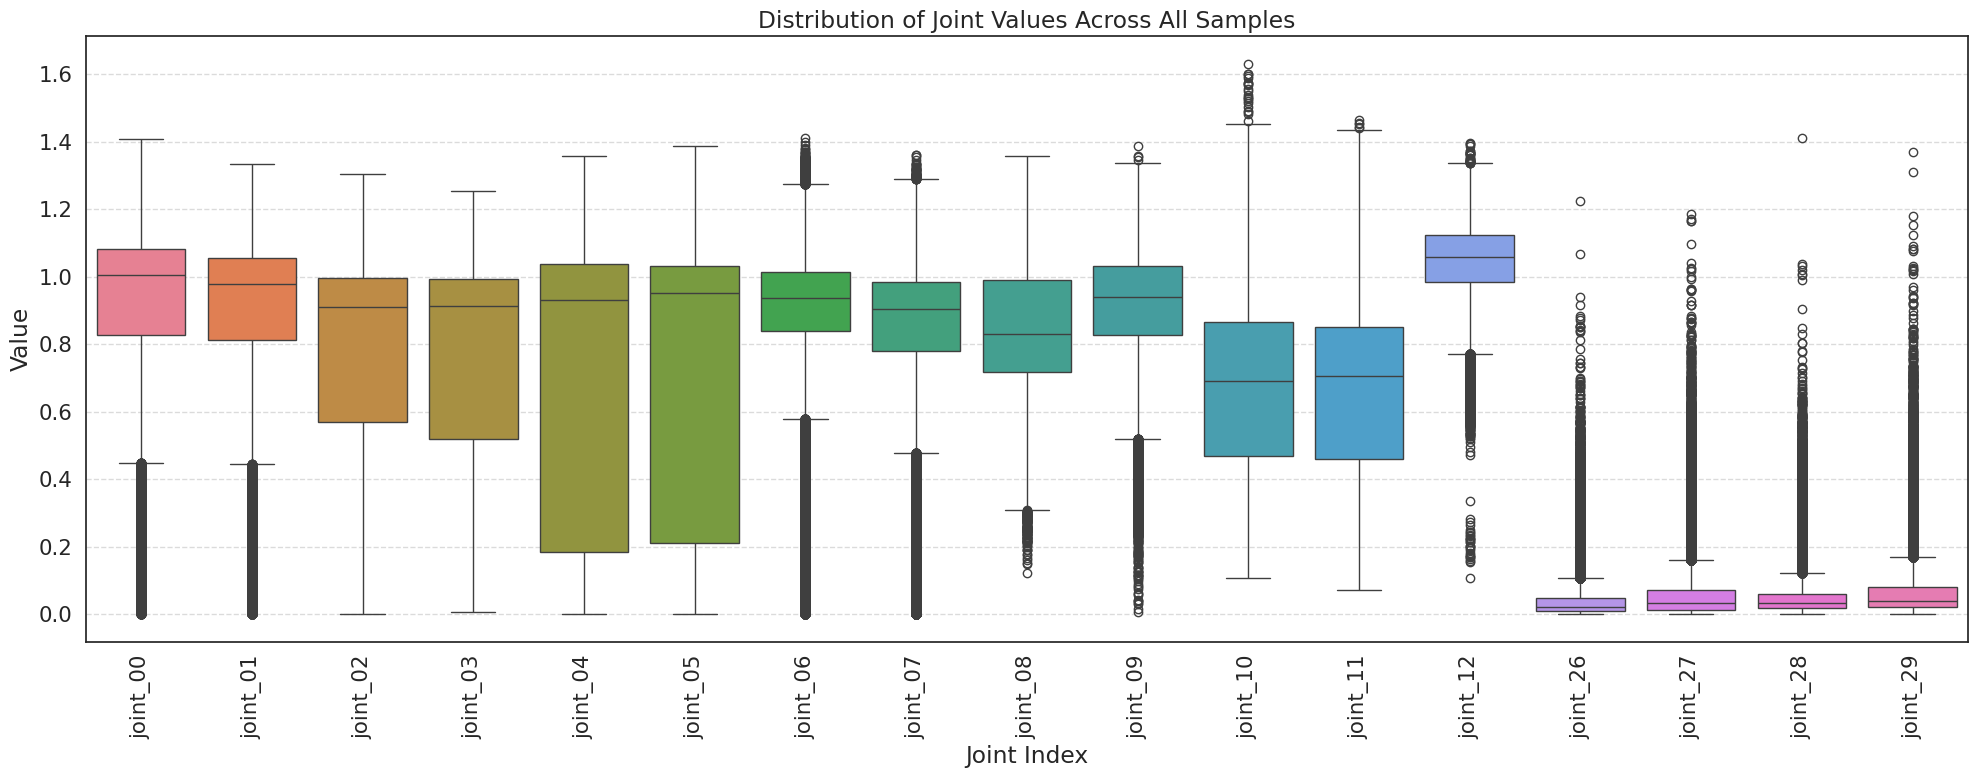

In [ ]:
# @title 6.2 Updated Joint values distribution

# Identify all columns in the DataFrame that represent 'joint_' values.
# These columns contain the time-series sensor data for various joints.
joint_columns = [col for col in df.columns if col.startswith('joint_')]

# Create a new figure for the plot. The figsize is set large (20x8 inches)
# to ensure that all joint columns and their distributions are clearly visible,
# especially when there are many such columns.
plt.figure(figsize=(20, 8))

# Generate a box plot for each identified joint column.
# A box plot is excellent for visualizing the distribution of numerical data,
# showing the median, quartiles, and potential outliers for each joint's values
# across all recorded samples.
sns.boxplot(data=df[joint_columns])

# Set the title of the plot for clear identification of its content.
plt.title('Distribution of Joint Values Across All Samples')

# Label the x-axis to indicate that each box represents a 'Joint Index'.
plt.xlabel('Joint Index')

# Label the y-axis to represent the 'Value' measured by the joint sensors.
plt.ylabel('Value')

# Rotate the x-axis labels by 90 degrees.
# This is particularly useful when there are many joint columns,
# preventing labels from overlapping and improving readability.
plt.xticks(rotation=90)

# Add a horizontal grid to the plot (along the y-axis).
# This helps in visually estimating the values and understanding the spread of data.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the plot layout to prevent labels and plot elements from overlapping.
# This ensures that all components of the visualization are well-placed and readable.
plt.tight_layout()

# Display the generated plot.
plt.show()

# 7. VALIDATION SET, NORMALIZATION and LABEL MAPPING





In [36]:
# @title 7.1 Splitting Data into Training and Validation Sets

# Get all unique 'sample_index' values, representing the individual pirates.
unique_pirates = df['sample_index'].unique()
# Calculate the total number of unique pirates in the dataset.
n_pirates = len(unique_pirates)
print(f"Total number of pirates in the dataset: {n_pirates}")

# Set the random seed for reproducibility. This ensures that the shuffling of pirates
# is consistent across runs.
random.seed(SEED)
random.shuffle(unique_pirates)

# Define the number of unique users (pirates) to be allocated to the validation set.
N_VAL_USERS = 135 # this number can be changed

# Calculate the number of users to be allocated to the training set.
n_train_users = len(unique_pirates) - N_VAL_USERS

# Split the shuffled unique_pirates array into training and validation sets.
train_users = unique_pirates[:n_train_users]
val_users = unique_pirates[n_train_users:n_train_users + N_VAL_USERS]

# Create the training and validation DataFrames based on the selected user IDs.
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the newly created training and validation sets.
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Total number of pirates in the dataset: 661
Training set shape: (84160, 28)
Validation set shape: (21600, 28)


In [37]:
# @title 7.2 Normalization

# Define the columns that need to be normalized.
scale_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + \
                [f'joint_{ind:02d}' for ind in range(13)] + \
                ['joint_26', 'joint_27', 'joint_28', 'joint_29']

# Calculate the minimum and maximum values using only the training data (`df_train`).
# This is crucial to prevent data leakage from the validation or test sets.
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply Min-Max Normalization to the specified columns across all datasets, to scale the values between 0 and 1:
# training set (`df_train`), validation set (`df_val`), and test set (`df_test`).
# FORMULA: (x - min) / (max - min).
for column in scale_columns:

    # Normalise the training, validation and test set and ensure the data type is float32.
    df_train[column] = ((df_train[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)
    df_val[column] = ((df_val[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)
    df_test[column] = ((df_test[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

In [38]:
# @title 7.3 Static Features Extraction
# This assumes that for each 'sample_index', these static features remain constant throughout its time series.
# The result is a DataFrame where each row corresponds to a unique 'sample_index' and contains its static features.

# Define the columns that contain static features.
static_cols = ['n_legs', 'n_hands', 'n_eyes']

# Group the training DataFrame by 'sample_index' and take the first occurrence of the static columns.
static_train_df = df_train.groupby('sample_index')[static_cols].first().astype(np.float32)

# Perform the same operation for the validation DataFrame.
static_val_df   = df_val.groupby('sample_index')[static_cols].first().astype(np.float32)

# Perform the same operation for the test DataFrame.
static_test_df  = df_test.groupby('sample_index')[static_cols].first().astype(np.float32)

print("Static train shape:", static_train_df.shape)
print("Static val shape:", static_val_df.shape)
print("Static test shape:", static_test_df.shape)


Static train shape: (526, 3)
Static val shape: (135, 3)
Static test shape: (1324, 3)


In [39]:
# @title 7.4 Label Mapping

# Define a dictionary of activity names to be mappend into integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# 8.MODEL DEFINITION

In [40]:
WINDOW_SIZE= 60
STRIDE= 20

In [41]:
# @title 8.1 Build sequences from the dataset

# Define a function to build sequences from the dataset
def build_sequences(df, window=WINDOW_SIZE, stride=STRIDE, return_labels=True, feature_columns_to_extract=None):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    dataset = []
    labels = []
    sequence_ids = [] # New list to store sample_index for each sequence

    # Always use 'sample_index' as the ID column as per user request
    id_column = 'sample_index'

    # Always use 'label' as the label column as per user request
    label_column = 'label'

    # Use provided feature_columns_to_extract or default to all 'joint_' columns if not specified
    if feature_columns_to_extract is None:
        feature_columns_to_extract = [col for col in df.columns if col.startswith('joint_')]

    if not feature_columns_to_extract:
        raise ValueError("No feature columns provided or found for sequence building.")

    for current_id in df[id_column].unique():
        # Extract sensor data for the current ID using the specified feature columns
        temp_data = df[df[id_column] == current_id][feature_columns_to_extract].values

        # Handle cases where a user might have no data points (empty temp_data)
        if len(temp_data) == 0:
            continue

        current_label = None
        if return_labels:
            if label_column in df.columns:
                current_label = df[df[id_column] == current_id][label_column].values[0]
            else:
                # If labels are expected but the column is missing, raise an error
                raise KeyError(f"Label column '{label_column}' not found in DataFrame for ID {current_id} when labels are expected (return_labels=True).")
        # If return_labels is False, current_label remains None or is not used for appending

        # Calculate padding length to ensure full windows
        padding_len = window - (len(temp_data) % window)
        if padding_len == window: # If len(temp_data) is a multiple of window, no padding needed
            padding_len = 0

        # Create zero padding and concatenate with the data
        if padding_len > 0:
            padding = np.zeros((padding_len, temp_data.shape[1]), dtype='float32')
            temp_data = np.concatenate((temp_data, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_data):
            dataset.append(temp_data[idx:idx + window])
            if return_labels:
                labels.append(current_label) # Append the actual label
            else:
                labels.append(-1) # Append a placeholder if not returning labels, for shape consistency in list before converting to numpy
            sequence_ids.append(current_id) # Append the current_id for each sequence
            idx += stride

    dataset_np = np.array(dataset)
    labels_np = np.array(labels, dtype=np.int64) if return_labels else np.empty(0, dtype=np.int64)
    sequence_ids_np = np.array(sequence_ids)

    return dataset_np, labels_np, sequence_ids_np

In [42]:

# Get the list of actual joint columns present in the preprocessed dataframes
actual_joint_columns_global = [col for col in df_train.columns if col.startswith('joint_')]

# Generate sequences and labels for the training set
X_train, y_train, seq_ids_train = build_sequences(df_train, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences and labels for the validation set
X_val, y_val, seq_ids_val     = build_sequences(df_val, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences for the test set (without labels)
# df_test does not contain the 'label' column, so we set return_labels=False
X_test, _, seq_ids_test       = build_sequences(df_test, WINDOW_SIZE, STRIDE, return_labels=False, feature_columns_to_extract=actual_joint_columns_global)

# Print the shapes of the generated datasets and their labels
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"seq_ids_test shape: {seq_ids_test.shape}")

X_train shape: (3682, 60, 17), y_train shape: (3682,)
X_val shape: (945, 60, 17), y_val shape: (945,)
X_test shape: (9268, 60, 17)
seq_ids_test shape: (9268,)


In [43]:

def build_static_array_from_seq_ids(sequence_ids, static_df):
    """
    sequence_ids: array/list of sample_index for each window (in same order as X)
    static_df: DataFrame indexed by sample_index with columns static_cols
    Returns: numpy array shape (n_windows, n_static_features)
    """
    # Some seq ids might not be sorted; use .loc to fetch rows by index
    static_list = [ static_df.loc[idx].values for idx in sequence_ids ]
    return np.vstack(static_list).astype(np.float32)

# Create static arrays aligned with each window
X_train_static = build_static_array_from_seq_ids(seq_ids_train, static_train_df)
X_val_static   = build_static_array_from_seq_ids(seq_ids_val, static_val_df)
X_test_static  = build_static_array_from_seq_ids(seq_ids_test, static_test_df)

print("X_train_static shape:", X_train_static.shape)
print("X_val_static shape:", X_val_static.shape)
print("X_test_static shape:", X_test_static.shape)


X_train_static shape: (3682, 3)
X_val_static shape: (945, 3)
X_test_static shape: (9268, 3)


In [44]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [45]:
# Convert to tensors and create datasets with sequence + static + label
train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(X_train_static).float(),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(X_val_static).float(),
    torch.from_numpy(y_val).long()
)
# test dataset (no label)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(X_test_static).float()
)


In [46]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 32 #in this course don't exceed this, isn't useful

In [47]:
# @title 8.2 Data Loader

def make_loader(ds, batch_size, shuffle=True, drop_last=False, sampler=None):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle if sampler is None else False, # Disable shuffle if a sampler is provided
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
        sampler=sampler # Pass the sampler if provided
    )

In [5]:
# @title 8.3 Weighted Random Sampler

# Calculate class weights for WeightedRandomSampler based on y_train
# y_train is from the build_sequences output (numpy array of labels for each window)
class_sample_count = np.array([(y_train == t).sum() for t in np.unique(y_train)])

# Calculate class weights as total number of samples divided by class sample count
# This scales up the weights compared to 1.0 / count, but maintains relative proportions.
total_samples_in_y_train = len(y_train)
class_weights_sampler = total_samples_in_y_train / class_sample_count

# Create a weight for each sample in train_ds based on its class weight
# y_train_tensor is the labels part of train_ds, but y_train (numpy) is easier to work with here
samples_weight = np.array([class_weights_sampler[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight).float()

# Create the WeightedRandomSampler
train_sampler = WeightedRandomSampler(
    weights=np.sqrt(samples_weight),
    num_samples=len(samples_weight),
    replacement=True # Typically replacement=True for WeightedRandomSampler
)

# Create data loaders with different settings for each phase
# Use the sampler for the training loader to handle class imbalance
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=False)
# For validation, we typically want to evaluate on the true distribution, so no sampler is used.
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


NameError: name 'y_train' is not defined

In [49]:
print(f"Class sample counts (based on y_train):")
for i, count in enumerate(class_sample_count):
    print(f"  Class {i}: {count} samples")

print(f"\nClass weights for sampler (1.0 / count):")
for i, weight in enumerate(class_weights_sampler):
    print(f"  Class {i}: {weight:.5f}")

print(f"\nFirst 10 sample weights (for individual samples in train_ds):\n{samples_weight[:10]}")

Class sample counts (based on y_train):
  Class 0: 2849 samples
  Class 1: 518 samples
  Class 2: 315 samples

Class weights for sampler (1.0 / count):
  Class 0: 1.29238
  Class 1: 7.10811
  Class 2: 11.68889

First 10 sample weights (for individual samples in train_ds):
tensor([1.2924, 1.2924, 1.2924, 1.2924, 1.2924, 1.2924, 1.2924, 1.2924, 1.2924,
        1.2924])


In [50]:
# Get one batch from the training data loader
for xb, x_static_batch, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Static features batch shape:", x_static_batch.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([32, 60, 17])
Static features batch shape: torch.Size([32, 3])
Labels batch shape: torch.Size([32])


# 9.MODEL BUILDING

In [51]:
# @title 9.1 Recurrent Summary
def recurrent_summary(model, input_size, static_input_size=0):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
        static_input_size (int): Number of static features, if any. Defaults to 0.
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)
    dummy_static_input = None
    if static_input_size > 0:
        dummy_static_input = torch.randn(1, static_input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            if dummy_static_input is not None:
                model(dummy_input, dummy_static_input)
            else:
                model(dummy_input) # If no static input, call with only dynamic input
        except Exception as e:
            print(f"Error during dummy forward pass in recurrent_summary: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [52]:
# @title 9.2 Recurrent Classifier
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            static_size=0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.static_size = static_size


        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the hidden_to_classify (after RNN, before potential reduction)
        if self.bidirectional:
            classifier_input_size_from_rnn = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size_from_rnn = hidden_size


        # Calculate input size for the final classifier, incorporating static features
        final_classifier_input_size = classifier_input_size_from_rnn + self.static_size

        # Final classification layer as a small FFN with Leaky ReLU
        # Using final_classifier_input_size as a hidden layer for simplicity
        self.classifier = nn.Sequential(
            nn.Linear(final_classifier_input_size, final_classifier_input_size), # Hidden layer
            nn.LeakyReLU(), # Activation for hidden layer
            nn.Linear(final_classifier_input_size, num_classes) # Output layer
        )


    def forward(self, x, x_static=None):
        """
        x shape: (batch_size, seq_length, input_size)
        x_static shape: (batch_size, static_size) (optional)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, :, :]) and bwd (hidden[-1, 1, :, :])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1) # take the last layer and feed it into the classifier
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        if x_static is not None:
            # ensure same dtype/device
            x_static = x_static.to(hidden_to_classify.dtype)
            x_static = x_static.to(hidden_to_classify.device)
            hidden_to_classify = torch.cat([hidden_to_classify, x_static], dim=1)

        # Get logits from the sequential classifier
        logits = self.classifier(hidden_to_classify)
        return logits

In [53]:
# @title 9.3 Focal Loss

import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal Loss for multi-class classification.
    gamma > 0 reduces the relative loss for well-classified examples, focusing on hard ones.
    alpha balances classes if needed (tensor/list of weights per class).
    """
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                alpha = torch.tensor(alpha, dtype=torch.float)
            self.alpha = alpha
        else:
            self.alpha = None
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: raw logits from the model (shape [batch_size, num_classes])
            targets: class indices (shape [batch_size])
        """
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        focal_weight = (1 - probs) ** self.gamma

        # Gather log_probs for the true classes
        log_pt = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = focal_weight.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            alpha_t = self.alpha.to(inputs.device).gather(0, targets)
            loss = -alpha_t * focal_weight * log_pt
        else:
            loss = -focal_weight * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


# 10.HYPERPARAMETERS

## Architecture:

| Layer | Output Shape | Parameters |
|-------|--------------|-------------|
| Input | (window_size, n_features) | 0 |
| LSTM/GRU Layers | [-1, 60, 128], [4, -1, 64] | 148,480  |
| Dense Layer | [-1, 3]   | 17,558  |
| Output (Softmax, 3 classes) | (3,) | 0 |

### Training configuration:
- **Loss:** Focal Loss / Weighted Cross Entropy
- **Sampler:** WeightedRandomSampler / ADASYN-balanced dataset  
- **Optimizer:** AdamW
- **Early Stopping:** Enabled; Patience = 50  
- **Batch size:** 32  
- **Epochs:** 400

In [1]:
# @title 10.1 Hyperparameters & Model

# HYPERPARAMETERS
LEARNING_RATE = 1e-3
EPOCHS = 400
PATIENCE = 50

# MODEL
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 64

DROPOUT_RATE = 0.3
L1_LAMBDA = 0
L2_LAMBDA = 0

LABEL_SMOOTHING= 0

# SAMPLER CONTROL
USE_WEIGHTED_SAMPLER = False # Set to False to temporarily disable the WeightedRandomSampler

In [55]:
# @title 10.2 Class Weights for the Dataset Imbalance

# Calculate class weights for the imbalanced dataset
# Ensure y_train (numpy array) contains integer labels
class_labels = np.unique(y_train) # Use the global y_train (numpy array) that has integer labels
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)

class_weights_np[0]= 1*class_weights_np[0]
class_weights_np[1]= 1*class_weights_np[1]
class_weights_np[2]= 1*class_weights_np[2]

# Alternative: square root for smoothing the weights values
class_weights_np = np.sqrt(class_weights_np)

# Tensor conversion
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

In [56]:
# @title 10.3 Loss Function

# FocalLoss: useful for imbalanced datasets to reduce the impact of easy-to-classify examples
# gamma=1 controls how much the loss focuses on misclassified examples
# alpha = class weights computed above
criterion = FocalLoss(gamma=1, alpha=class_weights, reduction='mean')

# Alternative: CrossEntropy with class weights and label smoothing
# criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

In [57]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [58]:
# @title 10.4 Train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, static_inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs, static_inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [59]:
# @title 10.5 Validate one epoch
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, static_inputs, targets in val_loader:
            # Move data to device
            inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs, static_inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [60]:
# @title 10.6 Tensorboard Logging
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty and has variance before adding a histogram
            if param.numel() > 0 and param.data.std() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty, finite, and has variance before adding a histogram
                if param.grad.numel() > 0 and torch.isfinite(param.grad).all() and param.grad.data.std() > 0:
                    writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [61]:
# @title 10.7 Model fitting
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [62]:
# @title 10.8 Model creation

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM',
    static_size=X_train_static.shape[1]
    ).to(device)

# The current recurrent_summary does not deeply inspect nn.Sequential modules.
# I will manually provide the details for the new architecture.
# Parameters updated after removing the rnn_output_reducer
# If bidirectional: rnn_output_dim = HIDDEN_SIZE * 2 = 64 * 2 = 128
# Classifier input = rnn_output_dim + static_size = 128 + 3 = 131
# Classifier: (131 * 131 + 131) + (131 * 3 + 3) = 17162 + 396 = 17558
# Total parameters: 148,480 (RNN) + 17,558 (Classifier) = 166,038

print("-------------------------------------------------------------------------------")
print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
print("===============================================================================")
print(f"{'rnn (LSTM)':<25} {'[[-1, 60, 128], [4, -1, 64]]':<28} {'148,480':<18}")
print(f"{'classifier (Sequential)':<25} {'[-1, 3]':<28} {'17,558':<18}")
print("===============================================================================")
print(f"Total params: 166,038")
print(f"Trainable params: 166,038")
print(f"Non-trainable params: 0")
print("-------------------------------------------------------------------------------")

# Set up TensorBoard logging and save model architecture
experiment_name = "weighted_rand_sampler_focalloss_sqrtcw_noalpha" # Updated experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# The `writer.add_graph` call needs to be updated to pass the static_inputs as well
x_static_dummy = torch.randn(1, X_train_static.shape[1]).to(device)
writer.add_graph(rnn_model, (x, x_static_dummy))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 60, 128], [4, -1, 64]] 148,480           
classifier (Sequential)   [-1, 3]                      17,558            
Total params: 166,038
Trainable params: 166,038
Non-trainable params: 0
-------------------------------------------------------------------------------


# 11. TRAINING

In [63]:
# @title 11.1 Model training

%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name=experiment_name,
    patience=PATIENCE
    )

# Update best_performance with the actual best F1 score from training history
# The fit function restores the model to the best state, so best_performance should reflect that.
if max(training_history['val_f1']) > best_performance:
    best_performance = max(training_history['val_f1'])
    print(f"Updated best_performance to: {best_performance:.4f}")

Training 400 epochs...
Epoch   1/400 | Train: Loss=0.7880, F1 Score=0.4503 | Val: Loss=0.5251, F1 Score=0.7046
Epoch  10/400 | Train: Loss=0.2263, F1 Score=0.8469 | Val: Loss=0.3791, F1 Score=0.8138
Epoch  20/400 | Train: Loss=0.1157, F1 Score=0.9172 | Val: Loss=0.5471, F1 Score=0.8403
Epoch  30/400 | Train: Loss=0.1375, F1 Score=0.9121 | Val: Loss=0.4929, F1 Score=0.7593
Epoch  40/400 | Train: Loss=0.0490, F1 Score=0.9651 | Val: Loss=0.5030, F1 Score=0.8746
Epoch  50/400 | Train: Loss=0.0381, F1 Score=0.9664 | Val: Loss=0.4925, F1 Score=0.8694
Epoch  60/400 | Train: Loss=0.0189, F1 Score=0.9830 | Val: Loss=0.5270, F1 Score=0.8688
Epoch  70/400 | Train: Loss=0.0301, F1 Score=0.9731 | Val: Loss=0.4678, F1 Score=0.9000
Epoch  80/400 | Train: Loss=0.0750, F1 Score=0.9511 | Val: Loss=0.4592, F1 Score=0.8995
Epoch  90/400 | Train: Loss=0.0127, F1 Score=0.9895 | Val: Loss=0.4986, F1 Score=0.9014
Epoch 100/400 | Train: Loss=0.0746, F1 Score=0.9581 | Val: Loss=0.5230, F1 Score=0.8975
Epoch 110

In [64]:
# @title 11.2 Save Output

#Define the path to save the best model with a descriptive filename
output_model_path = f"models/{experiment_name}_best_model_f1_{best_performance:.4f}.pt"

# Save the state dictionary of the rnn_model (which holds the best weights)
torch.save(rnn_model.state_dict(), output_model_path)

print(f"Best model saved successfully to: {output_model_path}")

Best model saved successfully to: models/weighted_rand_sampler_focalloss_sqrtcw_noalpha_best_model_f1_0.9338.pt


In [65]:
# @title 11.3 Inverse Label mapping & Test Data Loader
# Map numeric predictions back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Create a DataLoader for the test set (no shuffling for inference)
# test_ds contains both sequential (X_test) and static (X_test_static) inputs
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)



In [66]:
# @title 11.4 Model Inference

# Set the model to evaluation mode
rnn_model.eval() # This assumes rnn_model is the model to be evaluated
all_test_predictions = []

# seq_ids_test maps each sequence back to its original sample_index
# We'll use this for grouping predictions later

# Perform inference on the test set
with torch.no_grad():     # Disable gradient computation for inference
    for inputs_batch, static_inputs_batch in test_loader:
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device)

        outputs = rnn_model(inputs_batch, static_inputs_batch)
        predictions = outputs.argmax(dim=1).cpu().numpy()
        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test,
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and take the mode as the final label
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)


final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

In [67]:
# @title 11.5 Save predictions
# Save to CSV
output_filename = f'pirate_pain_predictions_{experiment_name}.csv'
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"\nPredictions saved to {output_filename}")
display(final_predictions_df.head())
print(f"\nFile '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")


Predictions saved to pirate_pain_predictions_weighted_rand_sampler_focalloss_sqrtcw_noalpha.csv


,sample_index,predicted_label_numeric,predicted_label
0,0,0,no_pain
1,1,0,no_pain
2,2,0,no_pain
3,3,0,no_pain
4,4,0,no_pain



File 'pirate_pain_predictions_weighted_rand_sampler_focalloss_sqrtcw_noalpha.csv' is already saved to Google Drive at '/gdrive/My Drive/Challenge1-Datasets/pirate_pain_predictions_weighted_rand_sampler_focalloss_sqrtcw_noalpha.csv'


# 12.PLOTS

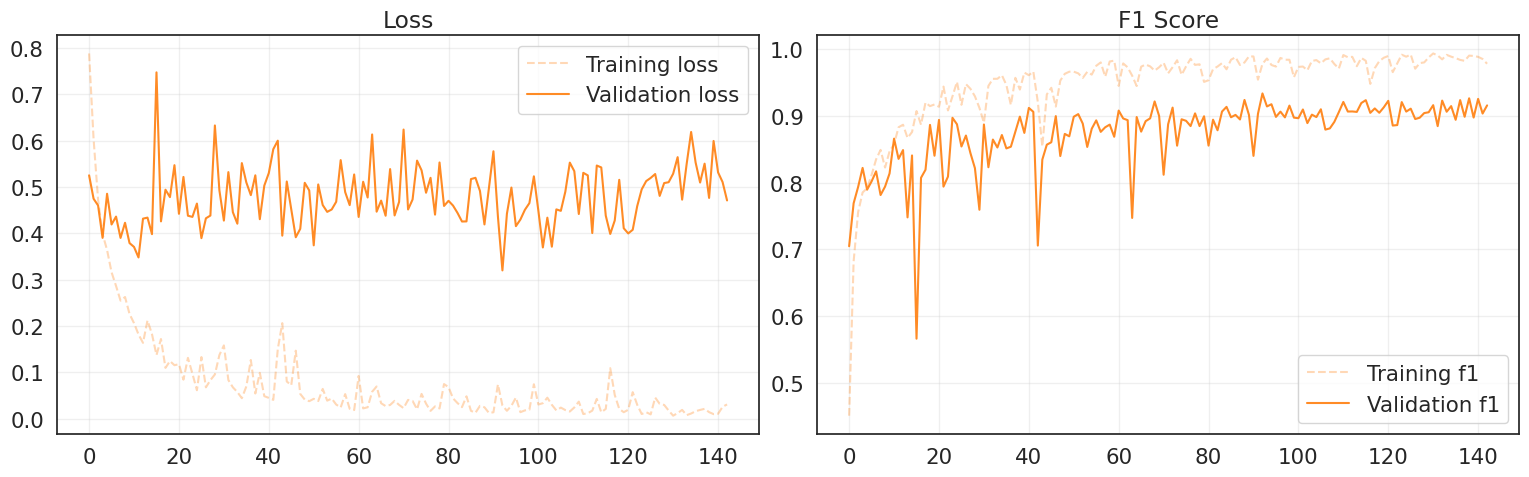

In [68]:
# @title 12.1 Plot History

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9344
Precision over the validation set: 0.9336
Recall over the validation set: 0.9344
F1 score over the validation set: 0.9338


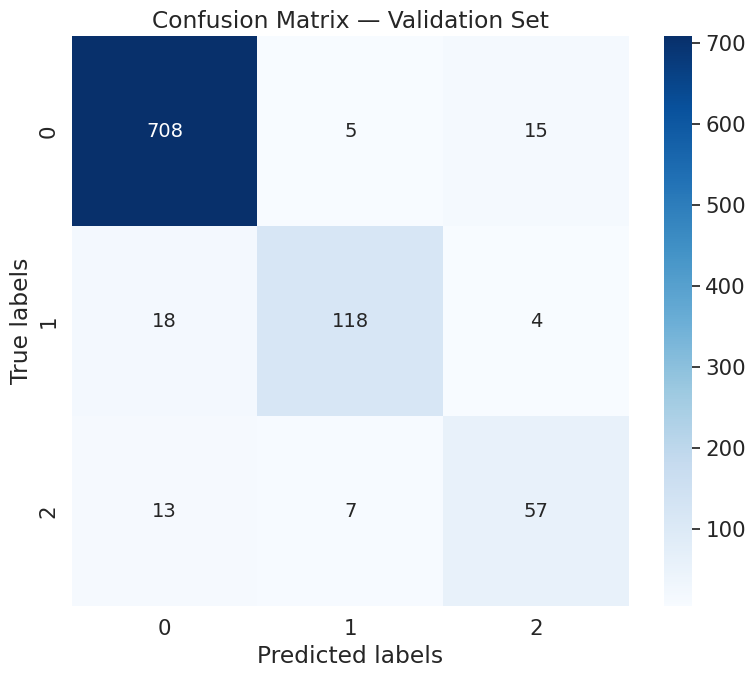

In [69]:
# @title 12.2 Plot Confusion Matrix

# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, x_static_batch, yb in val_loader:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

# 13.CROSS VALIDATION

In [ ]:
# @title 13.1 Setup & Hyperparameters

# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 135         # Number of users for validation split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3      # Learning rate
BATCH_SIZE = 32           # Batch size
WINDOW_SIZE = 60          # Input window size
STRIDE = 20               # Input stride

# Architecture
HIDDEN_LAYERS = 2         # Hidden layers
HIDDEN_SIZE = 64          # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = True      # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2        # Dropout probability
L1_LAMBDA = 0             # L1 penalty
L2_LAMBDA = 0             # L2 penalty

LABEL_SMOOTHING= 0

# Loss Function

# FocalLoss
# criterion = nn.FocalLoss(gamma=1, alpha=class_weights, reduction='mean')

# Cross Entropy with class weights and optional label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

In [ ]:
# @title 13.2 K-shuffle definition (adapted to the additional layer to divide static & dynamic features)
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda, l2_lambda, patience, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'label', 'pain_survey_X', 'n_X', 'joint_XX']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    label_col = 'label'
    user_id_col = 'sample_index'

    # Get number of classes from the global df 'label' column
    label_mapping = {
        'no_pain': 0,
        'low_pain': 1,
        'high_pain': 2,
    }
    num_classes = len(label_mapping)

    # Store initial weights to reset model for each split
    # Model is created inside the loop to ensure fresh state for each split
    initial_state = None

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        unique_users = df[user_id_col].unique()
        random.seed(seed + split_idx) # Use seed for reproducibility across splits
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]

        # Create deep copies for each split to avoid modifying the original df or other splits
        df_train_split = df[df[user_id_col].isin(train_users)].copy()
        df_val_split = df[df[user_id_col].isin(val_users)].copy()

        # Apply label mapping to convert string labels to integers for the current split
        df_train_split['label'] = df_train_split['label'].map(label_mapping)
        df_val_split['label'] = df_val_split['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train_split.shape}")
            print(f"  Validation set shape: {df_val_split.shape}")

        # Dynamically identify feature columns for scaling and sequence building
        all_feature_cols = [col for col in df_train_split.columns if col not in [user_id_col, 'time', label_col]]
        feature_cols_for_sequence = [col for col in df_train_split.columns if col.startswith('joint_')]

        # Normalise features using training set statistics for *this split*
        # Calculate min/max only from the training split of the current fold
        mins = df_train_split[all_feature_cols].min()
        maxs = df_train_split[all_feature_cols].max()

        # Apply normalization and ensure float32 for all numerical feature columns in all splits
        for col in all_feature_cols:
            # Handle potential division by zero if max equals min (constant column)
            divisor = (maxs[col] - mins[col])
            if divisor == 0: # If column is constant, assign 0 (or keep original value, depending on desired behavior)
                df_train_split[col] = 0.0 # Or keep df_train_split[col] as is if it's already a constant
                df_val_split[col] = 0.0
            else:
                df_train_split[col] = ((df_train_split[col] - mins[col]) / divisor).astype(np.float32)
                df_val_split[col] = ((df_val_split[col] - mins[col]) / divisor).astype(np.float32)

        # Build sequences using the modified build_sequences functions
        X_train, y_train_split, seq_ids_train_split = build_sequences(df_train_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)
        X_val, y_val_split, seq_ids_val_split = build_sequences(df_val_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)

        # Also get static features for this split
        static_cols = ['n_legs', 'n_hands', 'n_eyes']
        static_train_df_split = df_train_split.groupby('sample_index')[static_cols].first().astype(np.float32)
        static_val_df_split   = df_val_split.groupby('sample_index')[static_cols].first().astype(np.float32)

        X_train_static = build_static_array_from_seq_ids(seq_ids_train_split, static_train_df_split)
        X_val_static   = build_static_array_from_seq_ids(seq_ids_val_split, static_val_df_split)


        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            # Note: There is no X_test processing within this CV function currently

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_train_static), torch.from_numpy(y_train_split)) # Using y_train_split
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_val_static), torch.from_numpy(y_val_split)) # Using y_val_split

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # The input size for the RNN is the number of features in the sequences
        rnn_input_size = len(feature_cols_for_sequence)

        # Initialise model inside the loop to ensure fresh state for each split
        model = RecurrentClassifier(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type,
            static_size=X_train_static.shape[1]
        ).to(device)

        # Calculate class weights for this split's training data
        split_class_labels = np.unique(y_train_split)
        split_class_weights_np = compute_class_weight(
            class_weight='balanced',
            classes=split_class_labels,
            y=y_train_split
        )
        split_class_weights_tensor = torch.tensor(split_class_weights_np, dtype=torch.float32).to(device)

        # Define criterion for this split with calculated weights
        split_criterion = nn.CrossEntropyLoss(weight=split_class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=split_criterion, # Pass the split-specific criterion
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        # Store the entire history for plotting purposes
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']

        # Also store the best single F1 score for mean/std calculation
        best_val_f1_in_split = max(training_history['val_f1'])
        # The best_val_loss_in_split is derived from the F1, we just need to ensure 'best_scores' gets the float
        best_scores[f"split_{split_idx}"] = best_val_f1_in_split

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
# @title 13.3 Training with k-fold

%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

Split 1/5
  Training set shape: (84160, 27)
  Validation set shape: (21600, 27)
  Training sequences shape: (3682, 60, 17)
  Validation sequences shape: (945, 60, 17)
Training 500 epochs...


Exception in thread Thread-11 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_

KeyboardInterrupt: 

In [ ]:
# @title 13.4 Save K-Fold's best model

# Assuming 'best_scores' (dictionary of F1 scores per split)
# and 'experiment_name' (e.g., 'gru_baseline') are available.

# Initialize variables
overall_best_f1_kfold = -1.0
best_split_index_kfold = -1

# Find the split with the highest F1 score
for i in range(K): # K = number of Cross Validation splits
    current_split_f1 = best_scores[f'split_{i}']
    if current_split_f1 > overall_best_f1_kfold:
        overall_best_f1_kfold = current_split_f1
        best_split_index_kfold = i

# Define destination and source paths
source_model_filename = f"gru_baseline/split_{best_split_index_kfold}_model.pt"
source_model_path = os.path.join("models", source_model_filename)

destination_model_filename = f"best_kfold_model_f1_{overall_best_f1_kfold:.4f}.pt"
destination_model_path = os.path.join("models", destination_model_filename)

# Ensure the source model file exists before copying
if os.path.exists(source_model_path):
    # Copy the best model from the best split to a new, descriptive filename
    shutil.copyfile(source_model_path, destination_model_path)
    print(f"Overall best K-fold model (F1: {overall_best_f1_kfold:.4f} from split {best_split_index_kfold}) saved to: {destination_model_path}")
else:
    print(f"Error: Best model for split {best_split_index_kfold} not found at {source_model_path}")
    print("Please ensure the K-fold cross-validation training was executed successfully.")

# Update the best_performance variable for consistency
best_performance = overall_best_f1_kfold


NameError: name 'best_scores' is not defined

In [ ]:
# @title 13.5 Inverse Label mapping & Test Dataloader

# Map numeric predictions back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# DataLoader for the test set (no shuffling for inference)
# test_ds already contains both sequential and static inputs
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)





In [ ]:
# @title 13.6 Load the best K-fold model

# best_kfold_model_path obtained from previous K-Fold selection step
# Recreate the model architecture with same hyperparameters used in the best K-Fold run
best_kfold_model_path = destination_model_path

model_for_prediction = RecurrentClassifier(
    input_size=len(actual_joint_columns_global),  # Number of sequential features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,                      # Number of output classes
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,                            # RNN type from best K-Fold run
    static_size=X_test_static.shape[1]            # Number of static features
).to(device)

# Load the state dictionary of the best K-fold model
model_for_prediction.load_state_dict(torch.load(best_kfold_model_path, map_location=device))
model_for_prediction.eval() # Set the loaded model to evaluation mode

NameError: name 'destination_model_path' is not defined

In [ ]:
# @title 13.7 Inference & Save Predictions

all_test_predictions = []

# Perform inference on the test set using the loaded best K-fold model
with torch.no_grad():
    for inputs_batch, static_inputs_batch in test_loader:
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device)

        outputs = model_for_prediction(inputs_batch, static_inputs_batch)
        predictions = outputs.argmax(dim=1).cpu().numpy()
        all_test_predictions.extend(predictions)

# Combine predictions with sample_index
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test,
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

NameError: name 'model_for_prediction' is not defined

# 14.K-FOLD PLOTS




NameError: name 'losses' is not defined

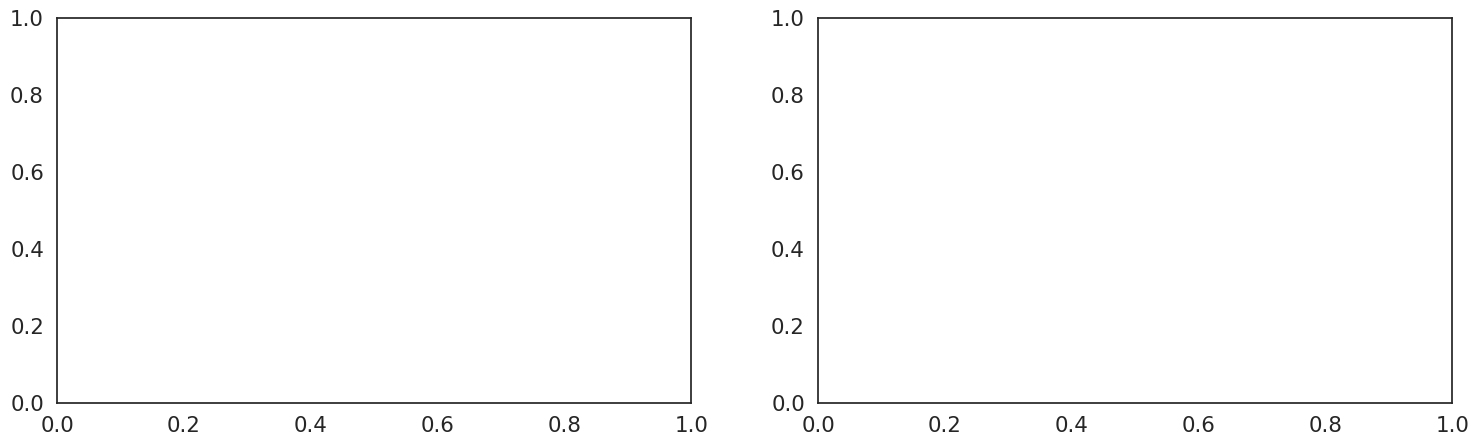

In [ ]:
# @title 14.1 Plot History
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [ ]:
# @title 14.2 Confusion Matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Re-create the validation data for the best performing split
label_col = 'label'
user_id_col = 'sample_index'
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}
# num_classes should be available globally, but we can re-derive it safely
num_classes_derived = len(label_mapping)

# Re-run the user splitting logic for the best split
unique_users = df[user_id_col].unique()
random.seed(SEED + best_split_index_kfold) # Use the same seed as that split
random.shuffle(unique_users)

n_train_users_best_split = len(unique_users) - N_VAL_USERS
train_users_best_split = unique_users[:n_train_users_best_split]
val_users_best_split = unique_users[n_train_users_best_split:n_train_users_best_split + N_VAL_USERS]

df_train_split_best = df[df[user_id_col].isin(train_users_best_split)].copy()
df_val_split_best = df[df[user_id_col].isin(val_users_best_split)].copy()

# Apply label mapping
df_train_split_best['label'] = df_train_split_best['label'].map(label_mapping)
df_val_split_best['label'] = df_val_split_best['label'].map(label_mapping)

# Dynamically identify feature columns for scaling and sequence building for this split
all_feature_cols_best_split = [col for col in df_train_split_best.columns if col not in [user_id_col, 'time', label_col]]
feature_cols_for_sequence_best_split = [col for col in df_train_split_best.columns if col.startswith('joint_')]

# Normalize features using training set statistics for this specific split
mins_best_split = df_train_split_best[all_feature_cols_best_split].min()
maxs_best_split = df_train_split_best[all_feature_cols_best_split].max()

for col in all_feature_cols_best_split:
    divisor = (maxs_best_split[col] - mins_best_split[col])
    if divisor == 0: # If column is constant, assign 0.0 for consistent typing
        df_train_split_best[col] = 0.0
        df_val_split_best[col] = 0.0
    else:
        df_train_split_best[col] = ((df_train_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)
        df_val_split_best[col] = ((df_val_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)

# Build sequences for validation set of best split
X_val_best_split, y_val_best_split, seq_ids_val_best_split = build_sequences(
    df_val_split_best, WINDOW_SIZE, STRIDE, feature_columns_to_extract=feature_cols_for_sequence_best_split
)

# Get static features for this split
static_cols = ['n_legs', 'n_hands', 'n_eyes']
static_val_df_best = df_val_split_best.groupby('sample_index')[static_cols].first().astype(np.float32)
X_val_static_best_split = build_static_array_from_seq_ids(seq_ids_val_best_split, static_val_df_best)

# Create DataLoader for the validation set of the best split
val_ds_best_split = TensorDataset(torch.from_numpy(X_val_best_split), torch.from_numpy(X_val_static_best_split), torch.from_numpy(y_val_best_split))
val_loader_best_split = make_loader(val_ds_best_split, BATCH_SIZE, shuffle=False, drop_last=False)

# Load the best K-fold model (destination_model_path should be available from earlier execution)
model_for_conf_matrix = RecurrentClassifier(
    input_size=len(feature_cols_for_sequence_best_split), # Use the dynamically determined number of joint features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes_derived,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    static_size=X_val_static_best_split.shape[1]
).to(device)

model_for_conf_matrix.load_state_dict(torch.load(destination_model_path, map_location=device))
model_for_conf_matrix.eval()

# Collect predictions and ground truth labels for the best split's validation set
val_preds_best_split, val_targets_best_split = [], []
with torch.no_grad():
    for xb, x_static_batch, yb in val_loader_best_split:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)
        logits = model_for_conf_matrix(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds_best_split.append(preds)
        val_targets_best_split.append(yb.numpy())

val_preds_best_split = np.concatenate(val_preds_best_split)
val_targets_best_split = np.concatenate(val_targets_best_split)

# Calculate overall validation metrics for this split
val_acc = accuracy_score(val_targets_best_split, val_preds_best_split)
val_prec = precision_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_rec = recall_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
print(f"Metrics for Validation Set of Best K-fold Split (Fold {best_split_index_kfold+1}):")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1 score: {val_f1:.4f}")

# Generate confusion matrix
cm_best_split = confusion_matrix(val_targets_best_split, val_preds_best_split)

# Map numeric labels back to string labels for better readability in the plot
inverse_label_mapping = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
class_labels = [inverse_label_mapping[i] for i in sorted(inverse_label_mapping.keys())]

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm_best_split, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels
           )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix — Validation Set (Best K-fold Split Fold {best_split_index_kfold+1})')
plt.tight_layout()
plt.show()

NameError: name 'destination_model_path' is not defined

# 15.HYPERPARAMETER TUNING

In [ ]:
# @title 15.1 Grid Search

def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# @title 15.2 Grid search Parameters & Execution

%%time

# Define parameters to search
param_grid = {
    'window_size': [60, 90],
    'stride': [10, 15, 30],
}

# Fixed hyperparameters (not being tuned)
# These parameters are kept constant during the grid search

fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}


# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}


# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/6:
  window_size: 60
  stride: 10
Training 500 epochs...


KeyboardInterrupt: 

In [ ]:
# @title 15.3 K Top configurations

# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

NameError: name 'results' is not defined

In [ ]:
#

# %%time
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = [] # For aggregated confusion matrix
all_test_preds = []   # For aggregated confusion matrix

label_mapping = {
    'Walking': 0, 'Jogging': 1, 'Upstairs': 2,
    'Downstairs': 3, 'Sitting': 4, 'Standing': 5
}
scale_columns = ['x_axis', 'y_axis', 'z_axis']

# --- 2. Begin evaluation loop across the K splits ---
# K, SEED, N_VAL_USERS, N_TEST_USERS are defined globally
for split in range(K):
    print(f"Evaluating Split {split+1}/{K} using best config: {best_config_str}")

    # --- 3. Regenerate the exact data split for this fold ---
    # This logic must be identical to k_shuffle_split_cross_validation_round_rnn
    unique_users = df['user_id'].unique()
    random.seed(SEED + split) # Use the same CV seed
    random.shuffle(unique_users)

    n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS
    train_users = unique_users[:n_train_users]
    val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
    test_users = unique_users[n_train_users + N_VAL_USERS:]

    df_train = df[df['user_id'].isin(train_users)].copy()
    df_test = df[df['user_id'].isin(test_users)].copy()

    # --- 4. Preprocess the data ---
    df_train['activity'] = df_train['activity'].map(label_mapping)
    df_test['activity'] = df_test['activity'].map(label_mapping)

    # Normalise features (fit on THIS split's training data)
    mins = df_train[scale_columns].min()
    maxs = df_train[scale_columns].max()

    for column in scale_columns:
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column] + 1e-8)

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test, y_test = build_sequences(
        df_test,
        window=final_best_params['window_size'],
        stride=final_best_params['stride']
    )

    # --- 6. Create the Test DataLoader ---
    test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader  = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split+1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        input_size=X_test.shape[2], # num_features (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=len(label_mapping), # num_classes (6)
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split+1}.")
        continue

    model.eval() # Set model to evaluation mode

    # --- 9. Run predictions on the test set ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad(): # Disable gradient computation for inference
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(yb.numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"  Test F1 Score for Split {split+1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)


# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} ± {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")


# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()